# import modules

In [1]:
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input,regularizers
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply,BatchNormalization,MaxPool1D
from keras.models import Model
import time

from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np
from keras.wrappers import scikit_learn

# Load Features

In [2]:
y=np.load('y_initial.npy')
X_features=np.load('X_gabor.npy')

In [3]:
X_features.shape

(4704, 35, 7)

In [4]:
y.shape

(4704, 2)

In [5]:
y[0]

array(['1', '0'], dtype='<U2')

In [6]:
alphabet_set={'0': 0,'b': 1, 'c': 2,'d': 3,'f': 4,'g': 5,'h': 6,'j': 7,'k': 8,'l': 9, 'm': 10,'n': 11,'p': 12,'q': 13,
          'r': 14,'s': 15,'t': 16,'w': 17,'x': 18,'y': 19,'z': 20}

In [7]:
alphabet_set={value:key for key,value in alphabet_set.items()}

## One-hot Encoding

In [8]:
y=to_categorical(y,num_classes=21)

In [9]:
y.shape

(4704, 2, 21)

## split train and test

In [10]:
np.random.seed(116)
np.random.shuffle(X_features)
np.random.seed(116)
np.random.shuffle(y)
tf.random.set_seed(116)

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X_features,y,test_size=0.2,random_state=2019)

In [12]:
X_train.shape,X_test.shape

((3763, 35, 7), (941, 35, 7))

In [13]:
y_train.shape,y_test.shape

((3763, 2, 21), (941, 2, 21))

# Models


In [14]:
NUM_CLASSES=21
BATCH_SIZE=32
EPOCHS=100
MODEL_SAVE_PATH='.\model\initial_gabor_cnn.h5'

In [15]:
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax', name='attention')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model():
    inputs = Input(shape=(35, 7))
    x=BatchNormalization()(inputs)
    x = Conv1D(filters = 32, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(x)  #, padding = 'same'
    x = MaxPool1D()(x)
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul=MaxPool1D(pool_size=10,strides=4)(attention_mul)
    output = Dense(21, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model


In [16]:
model = attention_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35, 7)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 35, 7)        28          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 35, 32)       256         batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 17, 32)       0           conv1d[0][0]                     
_______________________________________________________________________________________

In [17]:
# from keras.utils import plot_model
# plot_model(model, show_shapes=True)

In [18]:
a=time.time()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
plot_model(model,'model_initial.jpg',show_shapes=True)
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.2,
                  callbacks=callback_list)
b=time.time()
print("time=",b-a)

Epoch 1/100
94/95 [============================>.] - ETA: 0s - loss: 2.3786 - accuracy: 0.4318
Epoch 00001: val_accuracy improved from -inf to 0.44821, saving model to .\model\initial_gabor_cnn.h5
95/95 [==============================] - 2s 19ms/step - loss: 2.3781 - accuracy: 0.4319 - val_loss: 1.7622 - val_accuracy: 0.4482
Epoch 2/100
93/95 [============================>.] - ETA: 0s - loss: 1.7273 - accuracy: 0.4718
Epoch 00002: val_accuracy improved from 0.44821 to 0.48406, saving model to .\model\initial_gabor_cnn.h5
95/95 [==============================] - 1s 13ms/step - loss: 1.7272 - accuracy: 0.4718 - val_loss: 1.6916 - val_accuracy: 0.4841
Epoch 3/100
92/95 [============================>.] - ETA: 0s - loss: 1.6922 - accuracy: 0.4767
Epoch 00003: val_accuracy did not improve from 0.48406
95/95 [==============================] - 1s 11ms/step - loss: 1.6924 - accuracy: 0.4767 - val_loss: 1.6810 - val_accuracy: 0.4841
Epoch 4/100
91/95 [===========================>..] - ETA: 0s - 

90/95 [===========================>..] - ETA: 0s - loss: 1.3150 - accuracy: 0.5691
Epoch 00028: val_accuracy did not improve from 0.54648
95/95 [==============================] - 1s 10ms/step - loss: 1.3173 - accuracy: 0.5659 - val_loss: 1.4104 - val_accuracy: 0.5425
Epoch 29/100
95/95 [==============================] - ETA: 0s - loss: 1.2906 - accuracy: 0.5741
Epoch 00029: val_accuracy improved from 0.54648 to 0.55777, saving model to .\model\initial_gabor_cnn.h5
95/95 [==============================] - 1s 11ms/step - loss: 1.2906 - accuracy: 0.5741 - val_loss: 1.4103 - val_accuracy: 0.5578
Epoch 30/100
90/95 [===========================>..] - ETA: 0s - loss: 1.2726 - accuracy: 0.5797 ETA: 0s - loss: 1.283
Epoch 00030: val_accuracy did not improve from 0.55777
95/95 [==============================] - 1s 11ms/step - loss: 1.2723 - accuracy: 0.5807 - val_loss: 1.4168 - val_accuracy: 0.5511
Epoch 31/100
92/95 [============================>.] - ETA: 0s - loss: 1.2627 - accuracy: 0.5878
Ep

Epoch 56/100
94/95 [============================>.] - ETA: 0s - loss: 0.8715 - accuracy: 0.7166
Epoch 00056: val_accuracy did not improve from 0.56109
95/95 [==============================] - 1s 11ms/step - loss: 0.8720 - accuracy: 0.7164 - val_loss: 1.3765 - val_accuracy: 0.5611
Epoch 57/100
93/95 [============================>.] - ETA: 0s - loss: 0.8542 - accuracy: 0.7208
Epoch 00057: val_accuracy improved from 0.56109 to 0.56375, saving model to .\model\initial_gabor_cnn.h5
95/95 [==============================] - 1s 13ms/step - loss: 0.8539 - accuracy: 0.7204 - val_loss: 1.3940 - val_accuracy: 0.5637
Epoch 58/100
93/95 [============================>.] - ETA: 0s - loss: 0.8532 - accuracy: 0.7199
Epoch 00058: val_accuracy did not improve from 0.56375

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
95/95 [==============================] - 1s 11ms/step - loss: 0.8533 - accuracy: 0.7203 - val_loss: 1.3836 - val_accuracy: 0.5571
Epoch 59/100
90/95 [======

Epoch 83/100
94/95 [============================>.] - ETA: 0s - loss: 0.7793 - accuracy: 0.7493
Epoch 00083: val_accuracy did not improve from 0.56707
95/95 [==============================] - 1s 11ms/step - loss: 0.7795 - accuracy: 0.7493 - val_loss: 1.3871 - val_accuracy: 0.5637
Epoch 84/100
93/95 [============================>.] - ETA: 0s - loss: 0.7857 - accuracy: 0.7488
Epoch 00084: val_accuracy did not improve from 0.56707
95/95 [==============================] - 1s 11ms/step - loss: 0.7865 - accuracy: 0.7480 - val_loss: 1.3876 - val_accuracy: 0.5637
Epoch 85/100
91/95 [===========================>..] - ETA: 0s - loss: 0.7807 - accuracy: 0.7503
Epoch 00085: val_accuracy did not improve from 0.56707
95/95 [==============================] - 1s 11ms/step - loss: 0.7796 - accuracy: 0.7503 - val_loss: 1.3899 - val_accuracy: 0.5624
Epoch 86/100
90/95 [===========================>..] - ETA: 0s - loss: 0.7852 - accuracy: 0.7477
Epoch 00086: val_accuracy did not improve from 0.56707
95/95 

## plot_curve

In [ ]:
# from sklearn.metrics import classification_report
# model.load_weights('./models/pinyin_cnn.h5')

In [19]:
from help import plot_curve,plot_curve_with_smooth

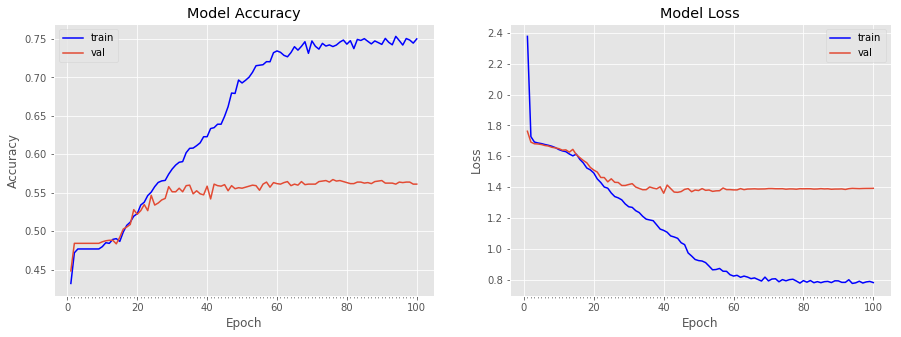

In [20]:
plot_curve(history)

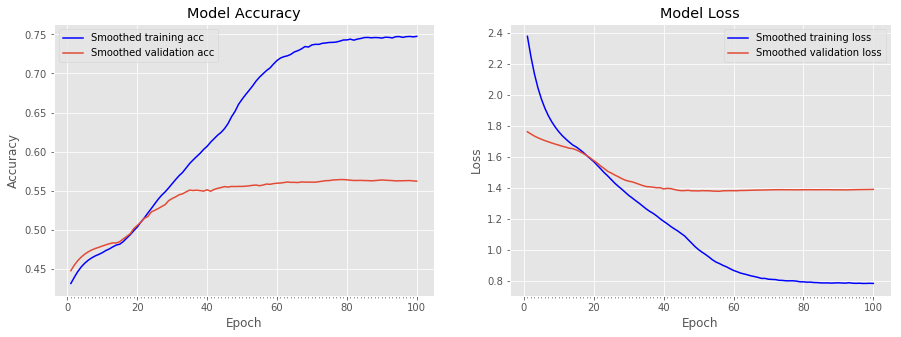

In [21]:
plot_curve_with_smooth(history)

## confusion_metrix

In [22]:
model.load_weights('./model/initial_gabor_cnn.h5')

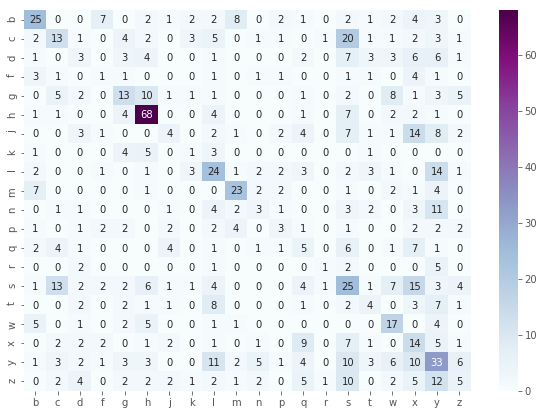

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_test,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
target_names=[alphabet_set[i] for i in range(1,21)]
# print(con_matrix)
con_matrix=con_matrix[1:,1:]
# print(con_matrix)
import seaborn as sn

df_cm = pd.DataFrame(con_matrix,
                     index = [i for i in list(target_names)],
                     columns = [i for i in list(target_names)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.20g',cmap="BuPu")
# def plot_confusion_matrix(confusion_mat):
#     plt.figure(figsize=(12,8))
#     plt.imshow(confusion_mat)
#     plt.title('Confusion Matrix')
#     plt.colorbar()
#     labels = list(range(0,21))
#     tick_marks = np.arange(len(labels))
#     plt.xticks(tick_marks, labels)
#     plt.yticks(tick_marks, labels)
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.grid(False)
#     plt.show() 
# plot_confusion_matrix(con_matrix)

## classfication_report

In [24]:
from sklearn.metrics import classification_report

In [25]:
target_names=[alphabet_set[i] for i in range(21)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(21)),target_names=target_names))

              precision    recall  f1-score   support

           0     0.8778    0.9667    0.9201       810
           b     0.4808    0.4032    0.4386        62
           c     0.2889    0.2063    0.2407        63
           d     0.1111    0.0750    0.0896        40
           f     0.0588    0.0625    0.0606        16
           g     0.3095    0.2321    0.2653        56
           h     0.5000    0.3542    0.4146       192
           j     0.2105    0.0800    0.1159        50
           k     0.0833    0.0625    0.0714        16
           l     0.3038    0.4000    0.3453        60
           m     0.5349    0.5349    0.5349        43
           n     0.1579    0.0938    0.1176        32
           p     0.1875    0.1154    0.1429        26
           q     0.1220    0.1471    0.1333        34
           r     0.2500    0.0909    0.1333        11
           s     0.2174    0.2717    0.2415        92
           t     0.1818    0.1250    0.1481        32
           w     0.3208    

# predict test

In [27]:

temp = np.load('che1.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:n


In [40]:

temp = np.load('./gabor/person1_time1_group1_ba_1.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:m


In [42]:

temp = np.load('./gabor/person1_time1_group1_he_2.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:h
